In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

/Users/shreeyachand/Downloads/cais-final-asl/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/shreeyachand/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1


In [3]:
resnet50 = models.resnet50(pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')
resnet50.to(device)

/Users/shreeyachand/Downloads/cais-final-asl/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/shreeyachand/Downloads/cais-final-asl/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /Users/shreeyachand/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/Users/shreeyachand/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quanti

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
train_path = path+'/asl_alphabet_train/asl_alphabet_train'
train_path

'/Users/shreeyachand/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train'

In [5]:
classes = list('ABCDEFGHIJKLMNOPQRSTUVWYXZ')
classes.append('del')
classes.append('nothing')
classes.append('del')

In [6]:
path_list = []
for i in classes:
    for j in range(3000):
        path_list.append(i+'/'+i+str(j+1)+'.jpg')

In [7]:
import os
from skimage import io
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [8]:
class ASLDataset(Dataset):
    def __init__(self, root_dir, path_list, transform=None):
        """
        Arguments:
            root_dir (string): Directory with all the images.
            path_list (list): List of all image paths.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.path_list = path_list
        self.transform = transform

    def __len__(self):
        return len(self.path_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.path_list[idx])
        image = io.imread(img_name)
        class_name = path_list[idx].split('/')[0]
        sample = {'imshow': image, 'class': torch.tensor(classes.index(class_name)), 'letter': class_name}


        if self.transform:
            sample['image'] = self.transform(sample['imshow'])


        return sample

In [9]:
import random

0 (200, 200, 3)
1 (200, 200, 3)
2 (200, 200, 3)
3 (200, 200, 3)


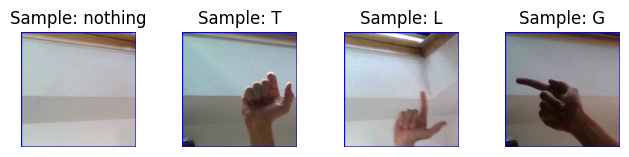

In [46]:
dataset = ASLDataset(root_dir=train_path, path_list=path_list, transform=transforms.ToTensor())

fig = plt.figure()

for i in range(4):
    sample = random.choice(dataset)
    print(i, sample['imshow'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample: {}'.format(sample['letter']))
    ax.axis('off')
    
    plt.imshow(sample['imshow'])

plt.show()

In [11]:
with torch.no_grad():
    output = torch.nn.functional.softmax(resnet50(sample['image'].unsqueeze(0).to(device)), dim=1) # unsqueeze bc only one sample, the other dim is batch size

results = utils.pick_n_best(predictions=output, n=5)

sample 0: [('hook, claw', '0.8%'), ('bucket, pail', '0.6%'), ("plunger, plumber's helper", '0.5%'), ('pole', '0.5%'), ('tennis ball', '0.5%')]


In [12]:
resnet50.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=29 # 26 letters + 3 characters
    ),
    torch.nn.Softmax()
)
resnet50.fc

Sequential(
  (0): Linear(in_features=2048, out_features=29, bias=True)
  (1): Softmax(dim=None)
)

In [13]:
# Freeze layers up to `layer3`
for name, layer in resnet50.named_children():
    if name in ['conv1', 'bn1', 'layer1', 'layer2']:
        for param in layer.parameters():
            param.requires_grad = False

In [15]:
train_set, val_set = torch.utils.data.random_split(dataset, [round(.7*len(dataset)), round(.3*len(dataset))])

In [16]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)

In [17]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet50.parameters())

In [18]:
train_losses = []
val_losses = []

In [19]:
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
num_epochs = 5
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data['image'].to(device)
        labels = data['class'].to(device)

        # zero the parameter gradients
        resnet50.train()
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet50(inputs).to(device)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % 200 == 0:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            train_losses.append(running_loss / 200)
            running_loss = 0.0

    resnet50.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs = data['image'].to(device)
            labels = data['class'].to(device)
            outputs = resnet50(inputs).to(device)
            val_loss += loss_function(outputs, labels).item()  # Sum up batch loss

    val_loss /= len(val_loader)  # Calculate average validation loss
    print("val loss for epoch " + str(epoch) + ": " + str(val_loss))
    val_losses.append(val_loss)

print('Finished Training')

/Users/shreeyachand/Downloads/cais-final-asl/venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[1,   200] loss: 3.224
[1,   400] loss: 3.159
[1,   600] loss: 3.070
[1,   800] loss: 3.031
[1,  1000] loss: 3.000
[1,  1200] loss: 2.945
[1,  1400] loss: 2.903
[1,  1600] loss: 2.878
[1,  1800] loss: 2.861
val loss for epoch 0: 2.86812649696481
[2,   200] loss: 2.847
[2,   400] loss: 2.843
[2,   600] loss: 2.839
[2,   800] loss: 2.814
[2,  1000] loss: 2.827
[2,  1200] loss: 2.819
[2,  1400] loss: 2.818
[2,  1600] loss: 2.812
[2,  1800] loss: 2.817
val loss for epoch 1: 2.8063828585778965
[3,   200] loss: 2.791
[3,   400] loss: 2.782
[3,   600] loss: 2.770
[3,   800] loss: 2.744
[3,  1000] loss: 2.748
[3,  1200] loss: 2.724
[3,  1400] loss: 2.707
[3,  1600] loss: 2.708
[3,  1800] loss: 2.684
val loss for epoch 2: 2.7322721089802537
[4,   200] loss: 2.777
[4,   400] loss: 2.696
[4,   600] loss: 2.658
[4,   800] loss: 2.612
[4,  1000] loss: 2.605
[4,  1200] loss: 2.611
[4,  1400] loss: 2.608
[4,  1600] loss: 2.605
[4,  1800] loss: 2.601
val loss for epoch 3: 2.595874151178435
[5,   200] 

In [24]:
resnet50.cpu()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [47]:
classes[int(torch.argmax(resnet50(sample['image'].unsqueeze(0))))]

'G'

'G'

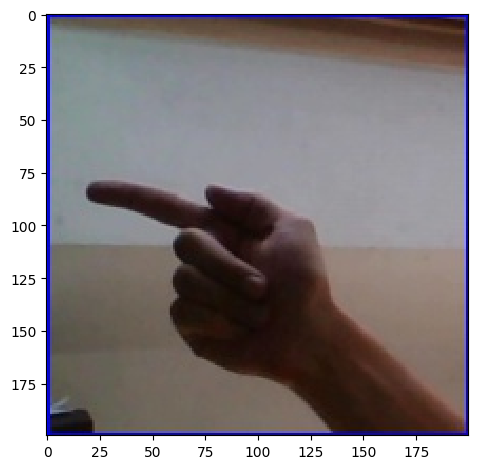

In [48]:
io.imshow(sample['imshow'])
sample['letter']

In [76]:
torch.save(resnet50, '5-epochs.pth') 

In [58]:
train_losses_plot = []

In [59]:
for i, loss in enumerate(train_losses):
    if (i+1) % 9 == 0:
        train_losses_plot.append(loss)

len(train_losses_plot)

5

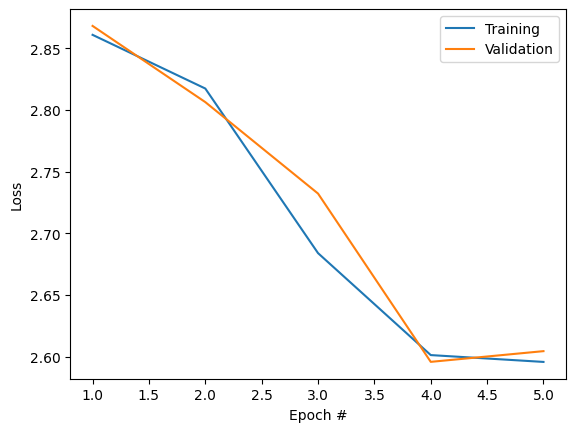

In [69]:
plt.plot(range(1,6),train_losses_plot, label="Training")
plt.plot(range(1,6),val_losses, label="Validation")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()